# Capstone Project - The Battle of Neighborhoods

# 1. Segmenting, Clustering and Explore Neighborhoods in Toronto, Canada

All imports

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors
# backend for rendering plots within the browser
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# to transform the data in the table on the Wikipedia page into the above pandas dataframe
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1.1. Download and Explore Dataset

In [2]:
# Read the wiki page
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikipedia_page= requests.get(url).text


soup = BeautifulSoup(wikipedia_page,'xml')
table = soup.find('table', {'class':'wikitable sortable'})

print(table.tr.text)


Postcode
Borough
Neighbourhood



In [3]:
# Replacing Neighbourhood (British English) with Neighborhood (American English)
table[2] = 'Neighborhood'

### Explore and clean Data, Creating Data Frame

In [4]:
rows = table.findAll('tr')
table_rows = []
for td in rows:
    cols = td.find_all('td')
    row = [col.text for col in cols]
    table_rows.append(row)
Postcode = pd.DataFrame(table_rows , columns = ['Postcode' , 'Borough', 'Neighborhood'])

#to remove \n
Postcode = Postcode.replace('\n','', regex=True)

#Ignoring all cells that are not assigned in Borough
New_Postcode = Postcode[Postcode['Borough'] != 'Not assigned']
New_Postcode.drop(New_Postcode.index[0], inplace=True)

#check for empty neighbourhoods to be replaced with borough
New_Postcode['Neighborhood'][9] = 'Queen\'s Park'

# Group Neghborhood by final_Postcode
final_Postcode = New_Postcode.groupby(['Postcode' , 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

print (final_Postcode.shape)

final_Postcode.head(10)

(103, 3)


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


## 1.2. To get the geographical coordinates of the neighborhoods

### Load geo_data

In [5]:
url2 = "http://cocl.us/Geospatial_data"
geo_data = pd.read_csv(url2)
geo_data.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


### Join latitude and longitude dataframe with neighborhood dataframe

In [6]:
geo_data = pd.read_csv(url2).drop(columns=['Postal Code'])

Toronto = pd.concat([final_Postcode, geo_data], axis=1, sort=False)
Toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## 1.3. Explore and cluster the neighborhoods in Toronto

#### Use geopy library to get the latitude and longitude values of Toronto

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'F5VTB4QM51E2YY12J1DCZPH33IQPS1M20NT0HYS3LXE2FJS5' # your Foursquare ID
CLIENT_SECRET = 'H0Q1E4R1JFAJDVGF0AJ03X0NIYEDINUN5JTQKS0X14XWAU1K' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F5VTB4QM51E2YY12J1DCZPH33IQPS1M20NT0HYS3LXE2FJS5
CLIENT_SECRET:H0Q1E4R1JFAJDVGF0AJ03X0NIYEDINUN5JTQKS0X14XWAU1K


### Now, let's get the top 100 venues that are in Toronto within a radius of 1000 meters

### Explore neighborhood in Toronto with Foursquare API

In [10]:
# Let's create a function to repeat the same process to all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius = 1000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# The code to run the above function on each neighborhood and create a new dataframe called toronto_venues
toronto_venues = getNearbyVenues(names = Toronto['Neighborhood'],
                                   latitudes = Toronto['Latitude'],
                                   longitudes = Toronto['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The D

#### The size of the resulting dataframe

In [13]:
print ("Found",  len(toronto_venues), "venues in", len(Toronto), "neighborhoods.")
toronto_venues.head()

Found 4861 venues in 103 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Rouge, Malvern",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
2,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,"Rouge, Malvern",43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant


In [14]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 329 uniques categories.


We found a lot of venues and restaurants, so it's better to focus just on one neighborhood. Let's count the number of restaurants in that area.

## 1.4. Get top 100 venues in each neighborhood (radius = 1000m), count the number of restaurants in that area

In [11]:
def getNrOfRestaurants(names, latitudes, longitudes, radius=1000, limit = 100):
    
    venues_count=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        restaurants_count = 0
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # count number of restaurant
        for v in results:
            if 'Restaurant' in v['venue']['categories'][0]['name']:
                restaurants_count = restaurants_count + 1
        
        # return only relevant information for each neighborhood
        venues_count.append([(
            name, 
            lat, 
            lng, 
            restaurants_count)])
            
    nearby_venues = pd.DataFrame([item for venue_count in venues_count for item in venue_count])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Number of restaurants']
    
    return(nearby_venues)

In [15]:
toronto_neigborhood_restaurant = getNrOfRestaurants(Toronto['Neighborhood'], Toronto['Latitude'], Toronto['Longitude'])
toronto_neigborhood_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of restaurants
0,"Rouge, Malvern",43.806686,-79.194353,7
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3
3,Woburn,43.770992,-79.216917,3
4,Cedarbrae,43.773136,-79.239476,8


In [16]:
# sort it by decreasing and print it out again
toronto_neigborhood_restaurant = toronto_neigborhood_restaurant.sort_values(by=['Number of restaurants'],ascending=False)
print("Total of all restaurants in Toronto:", toronto_neigborhood_restaurant['Number of restaurants'].sum())

toronto_neigborhood_restaurant.head()

Total of all restaurants in Toronto: 1213


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of restaurants
47,Davisville,43.704324,-79.388790,40
22,Willowdale South,43.770120,-79.408493,39
75,Christie,43.669542,-79.422564,34
41,"The Danforth West, Riverdale",43.679557,-79.352188,33
52,Church and Wellesley,43.665860,-79.383160,32


#### Davisville neighborhood has 40 restaurants, the most numeral restaurants. Lets explore more about Davisville and restaurants in Davisville

## 1.5. Davisville data

In [17]:
davisville_data = Toronto[Toronto['Neighborhood'] == 'Davisville'].reset_index(drop=True)
davisville_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4S,Central Toronto,Davisville,43.704324,-79.38879


### Let's visualize Davisville the neighborhoods in it.

In [18]:
address = 'Davisville, Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Davisville, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Davisville, CA are 43.7043123, -79.3885169.


In [19]:
# create map of Davisville using latitude and longitude values
map_davisville = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(davisville_data['Latitude'], davisville_data['Longitude'], davisville_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_davisville)  
    
map_davisville

#### Now, let's get the top 100 venues that are in Davisville within a radius of 1000 meters.

### Explore Davisville Neighborhood

#### The code to run the above function on each neighborhood and create a new dataframe called davisville_venues.

In [20]:
davisville_venues = getNearbyVenues(names=davisville_data['Neighborhood'],
                                    latitudes=davisville_data['Latitude'],
                                    longitudes=davisville_data['Longitude'])

Davisville


#### Let's check the size of the resulting dataframe

In [21]:
print(davisville_venues.shape)
davisville_venues

(100, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Davisville,43.704324,-79.38879,Thobors Boulangerie Patisserie Café,43.704514,-79.388616,Café
1,Davisville,43.704324,-79.38879,Jules Cafe Patisserie,43.704138,-79.388413,Dessert Shop
2,Davisville,43.704324,-79.38879,Marigold Indian Bistro,43.702881,-79.388008,Indian Restaurant
3,Davisville,43.704324,-79.38879,XO Gelato,43.705177,-79.388793,Dessert Shop
4,Davisville,43.704324,-79.38879,Viva Napoli,43.705752,-79.389125,Pizza Place
5,Davisville,43.704324,-79.38879,Istanbul Cafe & Espresso Bar,43.707891,-79.393049,Café
6,Davisville,43.704324,-79.38879,June Rowlands Park,43.700517,-79.389189,Park
7,Davisville,43.704324,-79.38879,Sakae Sushi,43.704944,-79.388704,Sushi Restaurant
8,Davisville,43.704324,-79.38879,Loblaws,43.707412,-79.394909,Supermarket
9,Davisville,43.704324,-79.38879,La Carnita,43.707533,-79.394500,Taco Place


In [22]:
# Let's check how many venues were returned for each neighborhood
davisville_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Davisville,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [23]:
print('There are {} uniques categories.'.format(len(davisville_venues['Venue Category'].unique())))

There are 57 uniques categories.


### Analyze Davisville Neighborhood

In [24]:
# one hot encoding
davisville_onehot = pd.get_dummies(davisville_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
davisville_onehot['Neighborhood'] = davisville_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [davisville_onehot.columns[-1]] + list(davisville_onehot.columns[:-1])
davisville_onehot = davisville_onehot[fixed_columns]

davisville_onehot.head()

,Neighborhood,Bakery,Bank,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Café,Caribbean Restaurant,Cemetery,Churrascaria,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Farmers Market,Fast Food Restaurant,French Restaurant,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Smoothie Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tennis Court,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Davisville,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Davisville,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Davisville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Davisville,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Davisville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
davisville_grouped = davisville_onehot.groupby('Neighborhood').mean().reset_index()
davisville_grouped

,Neighborhood,Bakery,Bank,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Café,Caribbean Restaurant,Cemetery,Churrascaria,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Farmers Market,Fast Food Restaurant,French Restaurant,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Smoothie Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tennis Court,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Davisville,0.01,0.01,0.02,0.01,0.01,0.01,0.04,0.01,0.01,0.01,0.07,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.03,0.01,0.02,0.04,0.01,0.07,0.01,0.03,0.02,0.01,0.01,0.01,0.03,0.01,0.02,0.01,0.03,0.01,0.02,0.01,0.01,0.01,0.01,0.06,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01


In [26]:
# Let's confirm the new size
davisville_grouped.shape

(1, 58)

#### Let's print each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in davisville_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = davisville_grouped[davisville_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Davisville----
                venue  freq
0         Coffee Shop  0.07
1  Italian Restaurant  0.07
2    Sushi Restaurant  0.06
3   Indian Restaurant  0.04
4                Café  0.04




#### Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = davisville_grouped['Neighborhood']

for ind in np.arange(davisville_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(davisville_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Davisville,Italian Restaurant,Coffee Shop,Sushi Restaurant,Indian Restaurant,Café,Pizza Place,Dessert Shop,Restaurant,Mexican Restaurant,Fast Food Restaurant


### To get all restaurants in Davisville

In [30]:
def getRestaurants(names, latitudes, longitudes, radius=1000, limit = 100):
    
    restaurants=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # list of restaurant
        for v in results:
            if 'Restaurant' in v['venue']['categories'][0]['name']:
                restaurants.append([name, lat, lng, v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']])
        return restaurants

davisville_restaurants = getRestaurants(davisville_data['Neighborhood'], davisville_data['Latitude'], davisville_data['Longitude'])
davisville_restaurants = pd.DataFrame(davisville_restaurants , columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
davisville_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Davisville,43.704324,-79.38879,5169d445e4b07de190b5c3d6,Marigold Indian Bistro,43.702881,-79.388008,Indian Restaurant
1,Davisville,43.704324,-79.38879,4b258fcef964a520d37324e3,Sakae Sushi,43.704944,-79.388704,Sushi Restaurant
2,Davisville,43.704324,-79.38879,4b939d18f964a520454a34e3,Zee Grill,43.704985,-79.388476,Seafood Restaurant
3,Davisville,43.704324,-79.38879,4bd4b2546798ef3bb235628d,Florentia Ristorante,43.703594,-79.387985,Italian Restaurant
4,Davisville,43.704324,-79.38879,521e0c6c04939a8ad55d93d3,Fresh,43.707324,-79.395649,Vegetarian / Vegan Restaurant
5,Davisville,43.704324,-79.38879,4ae86fb7f964a52053af21e3,Balsamico,43.701505,-79.397162,Italian Restaurant
6,Davisville,43.704324,-79.38879,53aca702498e3bbe34efc1bb,Little Sister,43.701552,-79.397163,Indonesian Restaurant
7,Davisville,43.704324,-79.38879,4da5f6cef7b16ce044af5212,Hokkaido Sushi,43.708082,-79.389995,Sushi Restaurant
8,Davisville,43.704324,-79.38879,4dcda6b7e4cd130e16534f51,Thai Spicy House,43.701962,-79.387513,Thai Restaurant
9,Davisville,43.704324,-79.38879,4aee242ef964a52077d221e3,Tabülè,43.700932,-79.397078,Middle Eastern Restaurant


#### Now we have 40 restaurants, but we still don't know which restaurant is the best. Let's pull some more informations about likes by restaurants from Fouresquere

In [31]:
restaurants_by_likes_to=[]

# loop through the Venue ID
for index, row in davisville_restaurants.iterrows():
    #print(row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'])
    
    # Within the loop, for each element in the table, you call the call 'likes' and put the venue id in the call
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
        row['Venue ID'],
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
            
    # make the GET request
    likes = requests.get(url).json()["response"]['likes']['count']
    
    # In the new list restaurants_by_likes append venue ID, Name, and Likes
    restaurants_by_likes_to.append([row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'], likes])

# We write the result and create new DataFrame table
venues_by_likes_to = pd.DataFrame(restaurants_by_likes_to, columns = ['Venue ID', 'Venue','Venue Category', 'Venue Latitude', 'Venue Longitude', 'Likes'])

# We sort a new list of restaurants_by_likes of the most like to the smallest and write the top 10
venues_by_likes_to = venues_by_likes_to.sort_values(by=['Likes'],ascending=False)
top_ten_venues_by_likes_to = venues_by_likes_to.head(10)
top_ten_venues_by_likes_to

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
12,4ad4c061f964a520a2f720e3,Grazie Ristorante,Italian Restaurant,43.709329,-79.398823,124
4,521e0c6c04939a8ad55d93d3,Fresh,Vegetarian / Vegan Restaurant,43.707324,-79.395649,98
9,4aee242ef964a52077d221e3,Tabülè,Middle Eastern Restaurant,43.700932,-79.397078,89
6,53aca702498e3bbe34efc1bb,Little Sister,Indonesian Restaurant,43.701552,-79.397163,51
20,4ae24e96f964a5200e8d21e3,Coquine Restaurant,French Restaurant,43.702623,-79.397429,45
35,50353048e4b0c42300d9c847,A&W Canada,Fast Food Restaurant,43.706837,-79.397167,37
22,4ad4c060f964a5207ef720e3,Echo Sushi,Sushi Restaurant,43.701276,-79.397192,36
15,4b6b758ff964a520270a2ce3,Five Doors North,Italian Restaurant,43.702236,-79.397526,30
31,4b01ef6ef964a520ad4622e3,Sushi Rock Café,Sushi Restaurant,43.709089,-79.398641,29
14,53865482498edb61054992bd,Star King,Vietnamese Restaurant,43.708519,-79.398764,25


#### We will make another call to pull venue's overall rating and price for top_ten_venues_by_likes

In [32]:
# Rating - Numerical rating of the venue (0 through 10). Returned as part of an explore result, excluded in search results. Not all venues will have a rating.
# Price - An object containing the price tier from 1 (least pricey) - 4 (most pricey) and a message describing the price tier.
restaurants_by_rating_to = []
restaurants_by_price_to = []

# loop through the Venue ID
for index, row in top_ten_venues_by_likes_to.iterrows():
    #print(row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'])
    
    # Within the loop, for each element in the table, you call the call 'likes' and put the venue id in the call
    # create the API request URL
    url4 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row['Venue ID'], CLIENT_ID, CLIENT_SECRET, VERSION)
    url5 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row['Venue ID'], CLIENT_ID, CLIENT_SECRET, VERSION)
    
    rating = requests.get(url4).json()['response']['venue']['rating']
    price = requests.get(url5).json()['response']['venue']['price']
        
    # In the new list restaurants_by_likes and restaurants_by_rating, append venue ID, Name, and likes and rating
    restaurants_by_rating_to.append([row['Venue ID'], row['Venue'], rating])
    restaurants_by_price_to.append([row['Venue ID'], row['Venue'], price])

# We write the result and create new DataFrame table
venues_by_rating_to = pd.DataFrame(restaurants_by_rating_to, columns = ['Venue ID', 'Venue',  'Rating'])
venues_by_price_to = pd.DataFrame(restaurants_by_price_to, columns = ['Venue ID', 'Venue',  'Price'])

# First drop some columns and then join venus_by_likes and venus_by_rating in one DataFrame table
venues_by_rating_to = venues_by_rating_to.drop(columns = ['Venue ID', 'Venue'])
venues_by_price_to = venues_by_price_to.drop(columns = ['Venue ID', 'Venue'])

Davisville_likes_rating_price = pd.concat([top_ten_venues_by_likes_to, venues_by_rating_to, venues_by_price_to], axis=1, sort=False)


# We sort a new list of Davisville_likes_rating of the most like to the smallest and write the top 10, print it out the Davisville_likes_rating
Davisville_likes_rating_price = Davisville_likes_rating_price.sort_values(by=['Likes'],ascending=False)
Davisville_likes_rating_price = Davisville_likes_rating_price.head(10)
Davisville_likes_rating_price

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes,Rating,Price
12,4ad4c061f964a520a2f720e3,Grazie Ristorante,Italian Restaurant,43.709329,-79.398823,124.0,NaN,NaN
4,521e0c6c04939a8ad55d93d3,Fresh,Vegetarian / Vegan Restaurant,43.707324,-79.395649,98.0,7.5,"{'tier': 2, 'message': 'Moderate', 'currency':..."
9,4aee242ef964a52077d221e3,Tabülè,Middle Eastern Restaurant,43.700932,-79.397078,89.0,8.3,"{'tier': 2, 'message': 'Moderate', 'currency':..."
6,53aca702498e3bbe34efc1bb,Little Sister,Indonesian Restaurant,43.701552,-79.397163,51.0,7.5,"{'tier': 2, 'message': 'Moderate', 'currency':..."
20,4ae24e96f964a5200e8d21e3,Coquine Restaurant,French Restaurant,43.702623,-79.397429,45.0,NaN,NaN
35,50353048e4b0c42300d9c847,A&W Canada,Fast Food Restaurant,43.706837,-79.397167,37.0,NaN,NaN
22,4ad4c060f964a5207ef720e3,Echo Sushi,Sushi Restaurant,43.701276,-79.397192,36.0,NaN,NaN
15,4b6b758ff964a520270a2ce3,Five Doors North,Italian Restaurant,43.702236,-79.397526,30.0,NaN,NaN
31,4b01ef6ef964a520ad4622e3,Sushi Rock Café,Sushi Restaurant,43.709089,-79.398641,29.0,NaN,NaN
14,53865482498edb61054992bd,Star King,Vietnamese Restaurant,43.708519,-79.398764,25.0,NaN,NaN


### Let's visualize this restaurants, top 10 restaurants by likes (red marks) and other Davisville restaurants (blue marks)

In [33]:
address = 'Davisville, Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Davisville, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Davisville, CA are 43.7043123, -79.3885169.


In [34]:
# create map of Davisville using latitude and longitude values
map_davisville_restaurants = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map (Davisville other restaurants - blue marks)
for lat, lng, poi in zip(davisville_restaurants['Venue Latitude'], davisville_restaurants['Venue Longitude'], davisville_restaurants['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_davisville_restaurants)  

# (top 10 restaurants by likes - red marks)
for lat, lon, poi in zip(top_ten_venues_by_likes_to['Venue Latitude'], top_ten_venues_by_likes_to['Venue Longitude'], top_ten_venues_by_likes_to['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_davisville_restaurants)

map_davisville_restaurants

### Explore attractions and visualizing attractions with restaurants
From top 100 venues of davisville_venues manually extract attractions for demonstration purposes

In [77]:
attractions = davisville_venues.loc[6], davisville_venues.loc[8], davisville_venues.loc[13], davisville_venues.loc[33], davisville_venues.loc[38], davisville_venues.loc[59], davisville_venues.loc[65], davisville_venues.loc[74]
venues_attractions = pd.DataFrame(attractions, columns = ['Venue', 'Venue Latitude',  'Venue Longitude', 'Venue Category'])
venues_attractions

,Venue,Venue Latitude,Venue Longitude,Venue Category
6,June Rowlands Park,43.700517,-79.389189,Park
8,Loblaws,43.707412,-79.394909,Supermarket
13,Granite Brewery,43.707991,-79.389943,Brewery
33,Yonge Eglinton Square,43.706864,-79.398751,Plaza
38,"Mysteriously Yours, Mystery Dinner Theatre",43.701222,-79.397251,General Entertainment
59,Mount Pleasant Cemetery,43.697384,-79.386286,Cemetery
65,Cineplex Cinemas Yonge-Eglinton,43.707500,-79.398601,Movie Theater
74,Snakes & Lattes,43.706879,-79.396646,Gaming Cafe


In [82]:
# Visualizing attractions with restaurants
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred Davisville

# Davisville restaurant map as a blue circle mark
for lat, lng, poi in zip(davisville_restaurants['Venue Latitude'], davisville_restaurants['Venue Longitude'], davisville_restaurants['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(venues_map)  

# top 10 restaurant map as a red circle mark
for lat, lon, poi in zip(top_ten_venues_by_likes_to['Venue Latitude'], top_ten_venues_by_likes_to['Venue Longitude'], top_ten_venues_by_likes_to['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(venues_map)


# add the trending venues as green circle markers
for lat, lng, label in zip(venues_attractions['Venue Latitude'], venues_attractions['Venue Longitude'], venues_attractions['Venue']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        poup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

# 2. Segmenting, Clustering and Explore Neighborhoods in New York City, USA

## 2.1. Download and Explore Dataset

Dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a wget command and access the data. So let's go ahead and do that.

In [83]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Load the data

In [84]:
# load the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
# Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Tranform the data into a pandas dataframe

In [85]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NewYorkCity = pd.DataFrame(columns=column_names)

In [86]:
# Take a look at the empty dataframe to confirm that the columns are as intended.
NewYorkCity

,Borough,Neighborhood,Latitude,Longitude


In [87]:
# Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NewYorkCity = NewYorkCity.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [88]:
# Quickly examine the resulting dataframe.
NewYorkCity.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [89]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NewYorkCity['Borough'].unique()),
        NewYorkCity.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


## 2.2. Explore the neighborhoods in New York City
### Use geopy library to get the latitude and longitude values of New York City.

In [90]:
# In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


### Create a map of New York with neighborhoods superimposed on top.

In [91]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NewYorkCity['Latitude'], NewYorkCity['Longitude'], NewYorkCity['Borough'], NewYorkCity['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Define Foursquare Credentials and Version
We have already did that in Toronto section and I don't need to repeat

#### Let's explore the first neighborhood in our dataframe.

#### Now, let's get the top 100 venues that are in New York City within a radius of 1000 meters.
We have already created a function to repeat the same process to all the neighborhoods, thats why we just call the getNearbyVenues function and create a new dataframe called newyork_venues.

In [95]:
# The code to run getNearbyVenues function on each neighborhood and create a new dataframe called newyork_venues.
newyork_venues = getNearbyVenues(names=NewYorkCity['Neighborhood'],
                                   latitudes=NewYorkCity['Latitude'],
                                   longitudes=NewYorkCity['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Let's check the size of the resulting dataframe

In [96]:
print(newyork_venues.shape)
newyork_venues.head()

(20487, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant


In [98]:
# Let's faund out the size of the resulting dataframe
print('{} venues in {} neighborhoods of New York City were returned by Foursquare.'.format(newyork_venues.shape[0], NewYorkCity.shape[0]))

20487 venues in 306 neighborhoods of New York City were returned by Foursquare.


In [100]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 464 uniques categories.


We found a lot of venues and restaurants, so it's better to focus just on one neighborhood. Let's count the number of restaurants in that area.

## 2.3. Get top 100 venues in each neighborhood (radius = 1000m), count the number of restaurants in that area
We have already created a function to repeat the same process to all the neighborhoods, thats why we just call the getNrOfRestaurants function

In [101]:
nyc_neigborhood_restaurant = getNrOfRestaurants(NewYorkCity['Neighborhood'], NewYorkCity['Latitude'], NewYorkCity['Longitude'])
nyc_neigborhood_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of restaurants
0,Wakefield,40.894705,-73.847201,10
1,Co-op City,40.874294,-73.829939,9
2,Eastchester,40.887556,-73.827806,12
3,Fieldston,40.895437,-73.905643,7
4,Riverdale,40.890834,-73.912585,11


In [102]:
# sort it by decreasing and print it out again
nyc_neigborhood_restaurant = nyc_neigborhood_restaurant.sort_values(by=['Number of restaurants'],ascending=False)
print("Total of all restaurants in New York City:", nyc_neigborhood_restaurant['Number of restaurants'].sum())

nyc_neigborhood_restaurant.head()

Total of all restaurants in New York City: 4925


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of restaurants
132,Elmhurst,40.744049,-73.881656,60
131,Jackson Heights,40.751981,-73.882821,56
138,Flushing,40.764454,-73.831773,47
130,Woodside,40.746349,-73.901842,43
126,Gramercy,40.737210,-73.981376,42


#### Elmhurst neighborhood has 60 restaurants, the most numeral restaurants. Lets explore more about Elmhurst and restaurants in Elmhurst neighborhood

## 2.4. Elmhurst data

In [103]:
elmhurst_data = NewYorkCity[NewYorkCity['Neighborhood'] == 'Elmhurst'].reset_index(drop=True)
elmhurst_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Elmhurst,40.744049,-73.881656


### Let's visualize Elmhurst the neighborhoods in it.

In [104]:
address = 'Elmhurst, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Elmhurst, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Elmhurst, NY are 40.7365804, -73.8783932.


In [105]:
# create map of Elmhurst using latitude and longitude values
map_elmhurst = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(elmhurst_data['Latitude'], elmhurst_data['Longitude'], elmhurst_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_elmhurst)  
    
map_elmhurst

### Now, let's get the top 100 venues that are in Elmhurst within a radius of 1000 meters.
### Explore Elmhurst Neighborhood
We have already created a function to repeat the same process to all the neighborhoods, thats why we just call the getNearbyVenues function and create a new dataframe called elmhurst_venues.

In [106]:
elmhurst_venues = getNearbyVenues(names=elmhurst_data['Neighborhood'],
                                    latitudes=elmhurst_data['Latitude'],
                                    longitudes=elmhurst_data['Longitude'])

Elmhurst


#### Let's check the size of the resulting dataframe

In [107]:
print(elmhurst_venues.shape)
elmhurst_venues

(100, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Elmhurst,40.744049,-73.881656,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...,40.743014,-73.883057,Thai Restaurant
1,Elmhurst,40.744049,-73.881656,Louie's Pizzeria and Restaurant,40.746051,-73.883723,Pizza Place
2,Elmhurst,40.744049,-73.881656,Taste Good Malaysian Cuisine 好味,40.741663,-73.882177,Malay Restaurant
3,Elmhurst,40.744049,-73.881656,La Fusta,40.744701,-73.884615,Argentinian Restaurant
4,Elmhurst,40.744049,-73.881656,Shell Cove,40.741009,-73.880130,Food
5,Elmhurst,40.744049,-73.881656,JoJu,40.740689,-73.879389,Vietnamese Restaurant
6,Elmhurst,40.744049,-73.881656,Lamoon,40.742850,-73.882913,Thai Restaurant
7,Elmhurst,40.744049,-73.881656,Lao Bei Fang,40.741078,-73.879996,Chinese Restaurant
8,Elmhurst,40.744049,-73.881656,Chao Thai ร้านชาวไทย,40.741416,-73.880102,Thai Restaurant
9,Elmhurst,40.744049,-73.881656,Dek Sen,40.741753,-73.878696,Thai Restaurant


In [108]:
# Let's check how many venues were returned for each neighborhood
elmhurst_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Elmhurst,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [109]:
print('There are {} uniques categories.'.format(len(elmhurst_venues['Venue Category'].unique())))

There are 42 uniques categories.


### Analyze Elmhurst Neighborhood

In [110]:
# one hot encoding
elmhurst_onehot = pd.get_dummies(elmhurst_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
elmhurst_onehot['Neighborhood'] = elmhurst_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [elmhurst_onehot.columns[-1]] + list(elmhurst_onehot.columns[:-1])
elmhurst_onehot = elmhurst_onehot[fixed_columns]

elmhurst_onehot.head()

,Neighborhood,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bank,Bar,Bubble Tea Shop,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Deli / Bodega,Dessert Shop,Diner,Food,Food Truck,Grocery Store,Gym / Fitness Center,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mexican Restaurant,Nightclub,Peruvian Restaurant,Pizza Place,Salon / Barbershop,Snack Place,South American Restaurant,Spanish Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Shop
0,Elmhurst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Elmhurst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Elmhurst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Elmhurst,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Elmhurst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [111]:
elmhurst_grouped = elmhurst_onehot.groupby('Neighborhood').mean().reset_index()
elmhurst_grouped

,Neighborhood,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bank,Bar,Bubble Tea Shop,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Deli / Bodega,Dessert Shop,Diner,Food,Food Truck,Grocery Store,Gym / Fitness Center,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mexican Restaurant,Nightclub,Peruvian Restaurant,Pizza Place,Salon / Barbershop,Snack Place,South American Restaurant,Spanish Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Shop
0,Elmhurst,0.01,0.02,0.04,0.06,0.01,0.02,0.04,0.02,0.01,0.06,0.01,0.02,0.01,0.01,0.02,0.02,0.01,0.04,0.02,0.01,0.01,0.01,0.03,0.03,0.01,0.04,0.01,0.07,0.01,0.02,0.02,0.01,0.01,0.05,0.01,0.01,0.02,0.11,0.01,0.01,0.03,0.01


In [112]:
# Let's confirm the new size
elmhurst_grouped.shape

(1, 43)

#### Let's print each neighborhood along with the top 5 most common venues

In [113]:
num_top_venues = 5

for hood in elmhurst_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = elmhurst_grouped[elmhurst_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Elmhurst----
                       venue  freq
0            Thai Restaurant  0.11
1         Mexican Restaurant  0.07
2                     Bakery  0.06
3         Chinese Restaurant  0.06
4  South American Restaurant  0.05




#### Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [114]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [115]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_nyc = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_nyc['Neighborhood'] = elmhurst_grouped['Neighborhood']

for ind in np.arange(elmhurst_grouped.shape[0]):
    neighborhoods_venues_sorted_nyc.iloc[ind, 1:] = return_most_common_venues(elmhurst_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_nyc.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Elmhurst,Thai Restaurant,Mexican Restaurant,Bakery,Chinese Restaurant,South American Restaurant,Latin American Restaurant,Asian Restaurant,Food Truck,Bubble Tea Shop,Vietnamese Restaurant


### All restaurants in Elmhurst
We have already created a function to repeat the same process to the neighborhood, thats why we just call the getRestaurants function and create a new dataframe called elmhurst_restaurants.

In [116]:
elmhurst_restaurants = getRestaurants(elmhurst_data['Neighborhood'], elmhurst_data['Latitude'], elmhurst_data['Longitude'])
elmhurst_restaurants = pd.DataFrame(elmhurst_restaurants , columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
elmhurst_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Elmhurst,40.744049,-73.881656,52f693e6498ed9d2a3fbad75,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...,40.743014,-73.883057,Thai Restaurant
1,Elmhurst,40.744049,-73.881656,4aa58ef5f964a520cc4820e3,Taste Good Malaysian Cuisine 好味,40.741663,-73.882177,Malay Restaurant
2,Elmhurst,40.744049,-73.881656,4b47d987f964a520794126e3,La Fusta,40.744701,-73.884615,Argentinian Restaurant
3,Elmhurst,40.744049,-73.881656,4e0f605462e1d5a30d0ab7ff,JoJu,40.740689,-73.879389,Vietnamese Restaurant
4,Elmhurst,40.744049,-73.881656,5abad6379de23b5eeb077b04,Lamoon,40.742850,-73.882913,Thai Restaurant
5,Elmhurst,40.744049,-73.881656,4eaf0752d3e30d448393b841,Lao Bei Fang,40.741078,-73.879996,Chinese Restaurant
6,Elmhurst,40.744049,-73.881656,4ad5173cf964a520c90121e3,Chao Thai ร้านชาวไทย,40.741416,-73.880102,Thai Restaurant
7,Elmhurst,40.744049,-73.881656,56e210f7cd102122a9fb1d1b,Dek Sen,40.741753,-73.878696,Thai Restaurant
8,Elmhurst,40.744049,-73.881656,4b26f895f964a5209d8324e3,Ayada Thai,40.743469,-73.887552,Thai Restaurant
9,Elmhurst,40.744049,-73.881656,54c63464498e753931c565da,Juquila Mexican Cuisine,40.747351,-73.882915,Mexican Restaurant


#### Now we have 60 restaurants, but we still don't know which restaurant is the best. Let's pull some more informations about likes by restaurants from Fouresquere

In [117]:
restaurants_by_likes_nyc=[]

# loop through the Venue ID
for index, row in elmhurst_restaurants.iterrows():
    #print(row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'])
    
    # Within the loop, for each element in the table, you call the call 'likes' and put the venue id in the call
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
        row['Venue ID'],
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
            
    # make the GET request
    likes = requests.get(url).json()["response"]['likes']['count']
    
    # In the new list restaurants_by_likes append venue ID, Name, and Likes
    restaurants_by_likes_nyc.append([row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'], likes])

# We write the result and create new DataFrame table
venues_by_likes_nyc = pd.DataFrame(restaurants_by_likes_nyc, columns = ['Venue ID', 'Venue','Venue Category', 'Venue Latitude', 'Venue Longitude', 'Likes'])

# We sort a new list of restaurants_by_likes of the most like to the smallest and write the top 10
venues_by_likes_nyc = venues_by_likes_nyc.sort_values(by=['Likes'],ascending=False)
top_ten_venues_by_likes_nyc = venues_by_likes_nyc.head(10)
top_ten_venues_by_likes_nyc

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
3,4e0f605462e1d5a30d0ab7ff,JoJu,Vietnamese Restaurant,40.740689,-73.879389,277
8,4b26f895f964a5209d8324e3,Ayada Thai,Thai Restaurant,40.743469,-73.887552,272
37,4db3747a1e7248d1358dc5c8,Phayul,Asian Restaurant,40.747165,-73.891373,151
10,4bd2b6ef9854d13abe3afc4d,Pollos a la Brasa Mario,South American Restaurant,40.747659,-73.884806,145
56,3fd66200f964a52009f11ee3,Jackson Diner,Indian Restaurant,40.747753,-73.891517,137
54,4ab56c26f964a520867420e3,Himalayan Yak,Tibetan Restaurant,40.746767,-73.892697,115
46,4b4d2b63f964a52032cd26e3,Thai Son,Vietnamese Restaurant,40.746463,-73.891562,112
1,4aa58ef5f964a520cc4820e3,Taste Good Malaysian Cuisine 好味,Malay Restaurant,40.741663,-73.882177,110
33,466a4c63f964a52099471fe3,Taqueria Coatzingo,Mexican Restaurant,40.747188,-73.889374,105
26,53af195d498e0a4a49420b68,Areperia Arepa Lady,Arepa Restaurant,40.747016,-73.888591,98


#### We will make another call to pull venue's overall rating and price for top_ten_venues_by_likes

In [118]:
# Rating - Numerical rating of the venue (0 through 10). Returned as part of an explore result, excluded in search results. Not all venues will have a rating.
# Price - An object containing the price tier from 1 (least pricey) - 4 (most pricey) and a message describing the price tier.
restaurants_by_rating_nyc = []
restaurants_by_price_nyc = []

# loop through the Venue ID
for index, row in top_ten_venues_by_likes_nyc.iterrows():
    #print(row['Venue ID'], row['Venue'], row['Venue Category'], row['Venue Latitude'], row['Venue Longitude'])
    
    # Within the loop, for each element in the table, you call the call 'likes' and put the venue id in the call
    # create the API request URL
    url8 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row['Venue ID'], CLIENT_ID, CLIENT_SECRET, VERSION)
    url9 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row['Venue ID'], CLIENT_ID, CLIENT_SECRET, VERSION)
    
    rating = requests.get(url8).json()['response']['venue']['rating']
    price = requests.get(url9).json()['response']['venue']['price']
        
    # In the new list restaurants_by_likes and restaurants_by_rating, append venue ID, Name, and likes and rating
    restaurants_by_rating_nyc.append([row['Venue ID'], row['Venue'], rating])
    restaurants_by_price_nyc.append([row['Venue ID'], row['Venue'], price])

# We write the result and create new DataFrame table
venues_by_rating_nyc = pd.DataFrame(restaurants_by_rating_nyc, columns = ['Venue ID', 'Venue',  'Rating'])
venues_by_price_nyc = pd.DataFrame(restaurants_by_price_nyc, columns = ['Venue ID', 'Venue',  'Price'])

# First drop some columns and then join venus_by_likes and venus_by_rating in one DataFrame table
venues_by_rating_nyc = venues_by_rating_nyc.drop(columns = ['Venue ID', 'Venue'])
venues_by_price_nyc = venues_by_price_nyc.drop(columns = ['Venue ID', 'Venue'])

Elmhurst_likes_rating_price = pd.concat([top_ten_venues_by_likes_nyc, venues_by_rating_nyc, venues_by_price_nyc], axis=1, sort=False)


# We sort a new list of Davisville_likes_rating of the most like to the smallest and write the top 10, print it out the Davisville_likes_rating
Elmhurst_likes_rating_price = Elmhurst_likes_rating_price.sort_values(by=['Likes'],ascending=False)
Elmhurst_likes_rating_price = Elmhurst_likes_rating_price.head(10)
Elmhurst_likes_rating_price

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes,Rating,Price
3,4e0f605462e1d5a30d0ab7ff,JoJu,Vietnamese Restaurant,40.740689,-73.879389,277.0,8.8,"{'tier': 2, 'message': 'Moderate', 'currency':..."
8,4b26f895f964a5209d8324e3,Ayada Thai,Thai Restaurant,40.743469,-73.887552,272.0,8.7,"{'tier': 1, 'message': 'Cheap', 'currency': '$'}"
37,4db3747a1e7248d1358dc5c8,Phayul,Asian Restaurant,40.747165,-73.891373,151.0,NaN,NaN
10,4bd2b6ef9854d13abe3afc4d,Pollos a la Brasa Mario,South American Restaurant,40.747659,-73.884806,145.0,NaN,NaN
56,3fd66200f964a52009f11ee3,Jackson Diner,Indian Restaurant,40.747753,-73.891517,137.0,NaN,NaN
54,4ab56c26f964a520867420e3,Himalayan Yak,Tibetan Restaurant,40.746767,-73.892697,115.0,NaN,NaN
46,4b4d2b63f964a52032cd26e3,Thai Son,Vietnamese Restaurant,40.746463,-73.891562,112.0,NaN,NaN
1,4aa58ef5f964a520cc4820e3,Taste Good Malaysian Cuisine 好味,Malay Restaurant,40.741663,-73.882177,110.0,9.3,"{'tier': 2, 'message': 'Moderate', 'currency':..."
33,466a4c63f964a52099471fe3,Taqueria Coatzingo,Mexican Restaurant,40.747188,-73.889374,105.0,NaN,NaN
26,53af195d498e0a4a49420b68,Areperia Arepa Lady,Arepa Restaurant,40.747016,-73.888591,98.0,NaN,NaN


### Let's visualize this restaurants, top 10 restaurants by likes (red marks) and other Elmhurst restaurants (blue marks)

In [119]:
address = 'Elmhurst, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Elmhurst, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Elmhurst, NY are 40.7365804, -73.8783932.


In [194]:
# create map of Elmhurst using latitude and longitude values
map_elmhurst_restaurants = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map (Elmhurst other restaurants - blue marks)
for lat, lng, poi in zip(elmhurst_restaurants['Venue Latitude'], elmhurst_restaurants['Venue Longitude'], elmhurst_restaurants['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_elmhurst_restaurants)  

# (top 10 restaurants by likes - red marks)
for lat, lon, poi in zip(top_ten_venues_by_likes_nyc['Venue Latitude'], top_ten_venues_by_likes_nyc['Venue Longitude'], top_ten_venues_by_likes_nyc['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_elmhurst_restaurants)

map_elmhurst_restaurants

### Explore attractions and visualizing attractions with restaurants
From top 100 venues of davisville_venues manually extract attractions for demonstration purposes.

Elmhurst neighborhood had no nearby attractions

# 3. A comparison between Toronto and New York City

In [121]:
# print top ten restaurants by likes in Davisville neighborhood
top_ten_venues_by_likes_to

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
12,4ad4c061f964a520a2f720e3,Grazie Ristorante,Italian Restaurant,43.709329,-79.398823,124
4,521e0c6c04939a8ad55d93d3,Fresh,Vegetarian / Vegan Restaurant,43.707324,-79.395649,98
9,4aee242ef964a52077d221e3,Tabülè,Middle Eastern Restaurant,43.700932,-79.397078,89
6,53aca702498e3bbe34efc1bb,Little Sister,Indonesian Restaurant,43.701552,-79.397163,51
20,4ae24e96f964a5200e8d21e3,Coquine Restaurant,French Restaurant,43.702623,-79.397429,45
35,50353048e4b0c42300d9c847,A&W Canada,Fast Food Restaurant,43.706837,-79.397167,37
22,4ad4c060f964a5207ef720e3,Echo Sushi,Sushi Restaurant,43.701276,-79.397192,36
15,4b6b758ff964a520270a2ce3,Five Doors North,Italian Restaurant,43.702236,-79.397526,30
31,4b01ef6ef964a520ad4622e3,Sushi Rock Café,Sushi Restaurant,43.709089,-79.398641,29
14,53865482498edb61054992bd,Star King,Vietnamese Restaurant,43.708519,-79.398764,25


In [122]:
# print top ten restaurants by likes in Elmhurst neighborhood
top_ten_venues_by_likes_nyc

,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
3,4e0f605462e1d5a30d0ab7ff,JoJu,Vietnamese Restaurant,40.740689,-73.879389,277
8,4b26f895f964a5209d8324e3,Ayada Thai,Thai Restaurant,40.743469,-73.887552,272
37,4db3747a1e7248d1358dc5c8,Phayul,Asian Restaurant,40.747165,-73.891373,151
10,4bd2b6ef9854d13abe3afc4d,Pollos a la Brasa Mario,South American Restaurant,40.747659,-73.884806,145
56,3fd66200f964a52009f11ee3,Jackson Diner,Indian Restaurant,40.747753,-73.891517,137
54,4ab56c26f964a520867420e3,Himalayan Yak,Tibetan Restaurant,40.746767,-73.892697,115
46,4b4d2b63f964a52032cd26e3,Thai Son,Vietnamese Restaurant,40.746463,-73.891562,112
1,4aa58ef5f964a520cc4820e3,Taste Good Malaysian Cuisine 好味,Malay Restaurant,40.741663,-73.882177,110
33,466a4c63f964a52099471fe3,Taqueria Coatzingo,Mexican Restaurant,40.747188,-73.889374,105
26,53af195d498e0a4a49420b68,Areperia Arepa Lady,Arepa Restaurant,40.747016,-73.888591,98


In [134]:
# reset the index for Davisville (can not call too many, but just twice)
top_ten_venues_by_likes_to1 = top_ten_venues_by_likes_to.reset_index(drop = True)
top_ten_venues_by_likes_to2 = top_ten_venues_by_likes_to1.reset_index(drop = False)
top_ten_venues_by_likes_to2

,index,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
0,0,4ad4c061f964a520a2f720e3,Grazie Ristorante,Italian Restaurant,43.709329,-79.398823,124
1,1,521e0c6c04939a8ad55d93d3,Fresh,Vegetarian / Vegan Restaurant,43.707324,-79.395649,98
2,2,4aee242ef964a52077d221e3,Tabülè,Middle Eastern Restaurant,43.700932,-79.397078,89
3,3,53aca702498e3bbe34efc1bb,Little Sister,Indonesian Restaurant,43.701552,-79.397163,51
4,4,4ae24e96f964a5200e8d21e3,Coquine Restaurant,French Restaurant,43.702623,-79.397429,45
5,5,50353048e4b0c42300d9c847,A&W Canada,Fast Food Restaurant,43.706837,-79.397167,37
6,6,4ad4c060f964a5207ef720e3,Echo Sushi,Sushi Restaurant,43.701276,-79.397192,36
7,7,4b6b758ff964a520270a2ce3,Five Doors North,Italian Restaurant,43.702236,-79.397526,30
8,8,4b01ef6ef964a520ad4622e3,Sushi Rock Café,Sushi Restaurant,43.709089,-79.398641,29
9,9,53865482498edb61054992bd,Star King,Vietnamese Restaurant,43.708519,-79.398764,25


In [152]:
# reset the index for Elmhurst (can not call to many, but just twice)
top_ten_venues_by_likes_nyc1 = top_ten_venues_by_likes_nyc.reset_index(drop = True)
top_ten_venues_by_likes_nyc2 = top_ten_venues_by_likes_nyc1.reset_index(drop = False)
top_ten_venues_by_likes_nyc2

,index,Venue ID,Venue,Venue Category,Venue Latitude,Venue Longitude,Likes
0,0,4e0f605462e1d5a30d0ab7ff,JoJu,Vietnamese Restaurant,40.740689,-73.879389,277
1,1,4b26f895f964a5209d8324e3,Ayada Thai,Thai Restaurant,40.743469,-73.887552,272
2,2,4db3747a1e7248d1358dc5c8,Phayul,Asian Restaurant,40.747165,-73.891373,151
3,3,4bd2b6ef9854d13abe3afc4d,Pollos a la Brasa Mario,South American Restaurant,40.747659,-73.884806,145
4,4,3fd66200f964a52009f11ee3,Jackson Diner,Indian Restaurant,40.747753,-73.891517,137
5,5,4ab56c26f964a520867420e3,Himalayan Yak,Tibetan Restaurant,40.746767,-73.892697,115
6,6,4b4d2b63f964a52032cd26e3,Thai Son,Vietnamese Restaurant,40.746463,-73.891562,112
7,7,4aa58ef5f964a520cc4820e3,Taste Good Malaysian Cuisine 好味,Malay Restaurant,40.741663,-73.882177,110
8,8,466a4c63f964a52099471fe3,Taqueria Coatzingo,Mexican Restaurant,40.747188,-73.889374,105
9,9,53af195d498e0a4a49420b68,Areperia Arepa Lady,Arepa Restaurant,40.747016,-73.888591,98


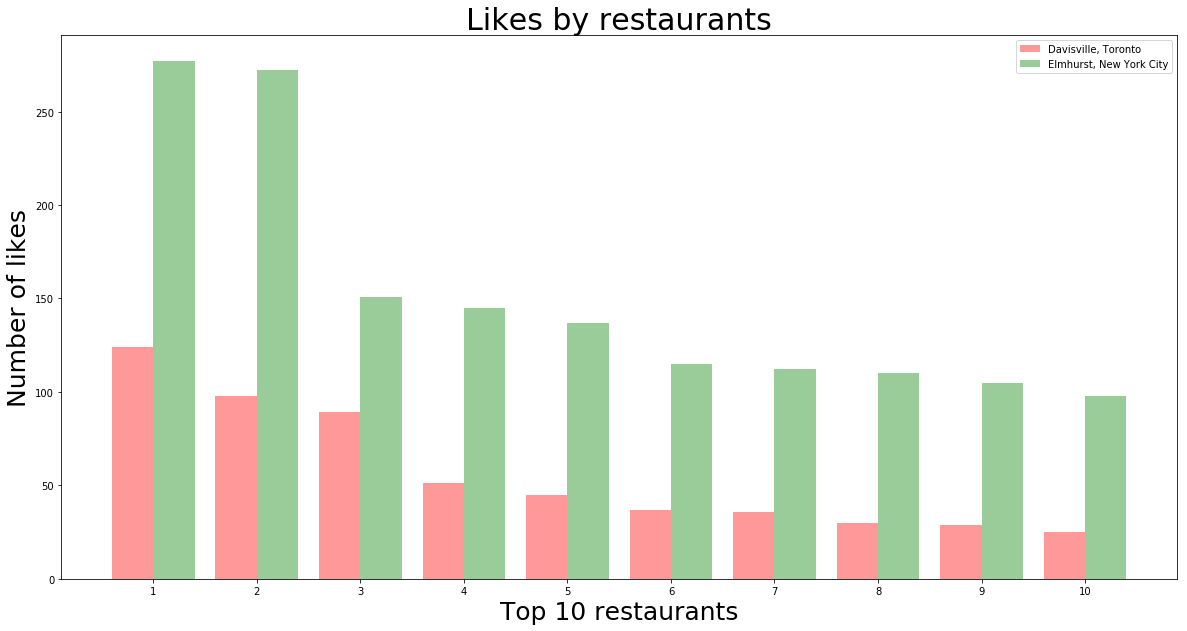

In [192]:
# ploting the bar chart
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

plt.bar(top_ten_venues_by_likes_to2.index - 0.2, top_ten_venues_by_likes_to2['Likes'], color = 'r', align='center', width = 0.4, alpha = 0.4, label = 'Davisville, Toronto')
plt.bar(top_ten_venues_by_likes_nyc2.index + 0.2, top_ten_venues_by_likes_nyc2['Likes'], color = 'g', align='center', width = 0.4, alpha = 0.4, label = 'Elmhurst, New York City')
plt.xlabel('Top 10 restaurants', fontsize=25)
plt.ylabel('Number of likes', fontsize=25)
plt.title('Likes by restaurants', fontsize=30)
plt.xticks(top_ten_venues_by_likes_to2.index, labels, rotation='horizontal')
plt.rcParams['figure.figsize']= (20,10)

plt.legend()
plt.show()